<center><h1>Last_First_HW4</h1></center>
<br>
<br>

Name: Brandon Han
<br>
Github Username: hanbrand
<br>
USC ID: 7263220420

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [21]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

Get the AReM Data Set

In [22]:
dataset_path = '../data/AReM'

def load_file(file_path):
    df = pd.read_csv(file_path, skiprows=4, sep=',')
    return df

def load_data(dataset_path):
    train_data = []
    test_data = []
    labels = []
    
    activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

    for folder in activity_folders:
        if 'pdf' in folder:
            continue
            
        folder_path = os.path.join(dataset_path, folder)

        if folder in ['bending1', 'bending2']:
            test_files = ['dataset1.csv', 'dataset2.csv']
        else:
            test_files = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name in test_files:
                df = load_file(file_path)
                test_data.append(df)
                labels.append(f'{folder} (test)')
            else:
                df = load_file(file_path)
                train_data.append(df)
                labels.append(f'{folder} (train)')

    return train_data, test_data, labels

def convert_to_numeric(data):
    for i in range(len(data)):
        data[i] = data[i].apply(pd.to_numeric, errors='coerce')
    return data

train_data, test_data, labels = load_data(dataset_path)
train_data = convert_to_numeric(train_data)
test_data = convert_to_numeric(test_data)

print("\nData type check after conversion for testing data:")
print(test_data[0].dtypes)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")









Data type check after conversion for testing data:
# Columns: time      int64
avg_rss12          float64
var_rss12          float64
avg_rss13          float64
var_rss13          float64
avg_rss23          float64
var_rss23          float64
dtype: object
Training data size: 69
Testing data size: 19


In [23]:
# Print the column names before feature extraction to check
print("Training data columns:")
print(train_data[0].columns)

print("Testing data columns:")
print(test_data[0].columns)


# Clean up the column names in both the training and testing data (remove unncessary port of the label)
for i in range(len(train_data)):
    train_data[i].columns = train_data[i].columns.str.replace('# Columns: ', '', regex=False)

for i in range(len(test_data)):
    test_data[i].columns = test_data[i].columns.str.replace('# Columns: ', '', regex=False)

# Check if the column names have been fixed
print("Cleaned training data columns:")
print(train_data[0].columns)

print("Cleaned testing data columns:")
print(test_data[0].columns)


Training data columns:
Index(['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23'],
      dtype='object')
Testing data columns:
Index(['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23'],
      dtype='object')
Cleaned training data columns:
Index(['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23'],
      dtype='object')
Cleaned testing data columns:
Index(['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23'],
      dtype='object')


### (b) Splitting Data

### (c) Feature Extraction

In [24]:
def extract_features_from_data(train_data, test_data):
    train_features = []
    test_features = []

    for df in train_data:
        train_features.append(extract_time_domain_features(df))  # Use the previously defined feature extraction function

    for df in test_data:
        test_features.append(extract_time_domain_features(df))   # Same for the test data

    # Convert to DataFrames
    train_features_df = pd.DataFrame(train_features)
    test_features_df = pd.DataFrame(test_features)

    return train_features_df, test_features_df

def extract_time_domain_features(df):
    features = {}
    
    for col in df.columns:
        # Fill NaN values with column mean or skip if column is entirely NaN
        if df[col].isnull().all():
            continue  # Skip entirely NaN columns
        
        numeric_col = pd.to_numeric(df[col], errors='coerce').fillna(df[col].mean())
        
        if numeric_col.isnull().any():
            print(f"Column '{col}' NaN")
        
        # Extract features
        features[f'{col}_min'] = numeric_col.min()
        features[f'{col}_max'] = numeric_col.max()
        features[f'{col}_mean'] = numeric_col.mean()
        features[f'{col}_median'] = numeric_col.median()
        features[f'{col}_std'] = numeric_col.std()
        features[f'{col}_1st_quartile'] = numeric_col.quantile(0.25)
        features[f'{col}_3rd_quartile'] = numeric_col.quantile(0.75)
    
    return features

def bootstrap_std_ci(data, n_iterations=1000, ci_level=90):
    bootstrapped_stds = []
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        # Resample the data with replacement
        sample = resample(data, replace=True)
        # Calculate standard deviation of the resampled data
        bootstrapped_stds.append(np.std(sample))
    
    # Calculate the percentiles for the confidence interval
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_stds, lower_percentile)
    upper_bound = np.percentile(bootstrapped_stds, upper_percentile)
    
    return lower_bound, upper_bound

train_features_df, test_features_df = extract_features_from_data(train_data, test_data)

# List of features to extract for each time series
features = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
# List of time series (columns) for which we want to extract the features
time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

new_dataset = []

for i in range(len(train_features_df)):  
    instance = []
    
    for ts in time_series:
        for feature in features:
            column_name = f'{ts}_{feature}'
            if column_name in train_features_df.columns:
                instance.append(train_features_df[column_name][i])
            else:
                instance.append(None)  # In case the feature is missing
    
    new_dataset.append(instance)

column_names = [f'{ts}_{feat}' for ts in time_series for feat in features]
final_df = pd.DataFrame(new_dataset, columns=column_names)
final_df.insert(0, 'Instance', range(1, len(final_df) + 1))

print(final_df.head()) 

# Part iii.
avg_rss12_std = final_df['avg_rss12_std']
ci_avg_rss12_std = bootstrap_std_ci(avg_rss12_std, n_iterations=1000, ci_level=90)
print(f"90% Bootstrap CI for 'avg_rss12_std': {ci_avg_rss12_std}")

# Iterate over all the columns in final_df to calculate standard deviation CIs
ci_results = {}

for column in final_df.columns[1:]:  # Skip the 'Instance' column
    std_ci = bootstrap_std_ci(final_df[column], n_iterations=1000, ci_level=90)
    ci_results[column] = std_ci

# Display the confidence intervals for each feature
for feature, ci in ci_results.items():
    print(f"90% CI for standard deviation of {feature}: {ci}")


   Instance  avg_rss12_min  avg_rss12_max  avg_rss12_mean  avg_rss12_median  \
0         1          35.00          47.40       43.954500             44.33   
1         2          33.00          47.75       42.179812             43.50   
2         3          33.00          45.75       41.678063             41.75   
3         4          37.00          48.00       43.454958             43.25   
4         5          36.25          48.00       43.969125             44.50   

   avg_rss12_std  avg_rss12_1st_quartile  avg_rss12_3rd_quartile  \
0       1.558835                   43.00                   45.00   
1       3.670666                   39.15                   45.00   
2       2.243490                   41.33                   42.75   
3       1.386098                   42.50                   45.00   
4       1.618364                   43.31                   44.67   

   var_rss12_min  var_rss12_max  ...  avg_rss23_std  avg_rss23_1st_quartile  \
0            0.0           1.70  ... 

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

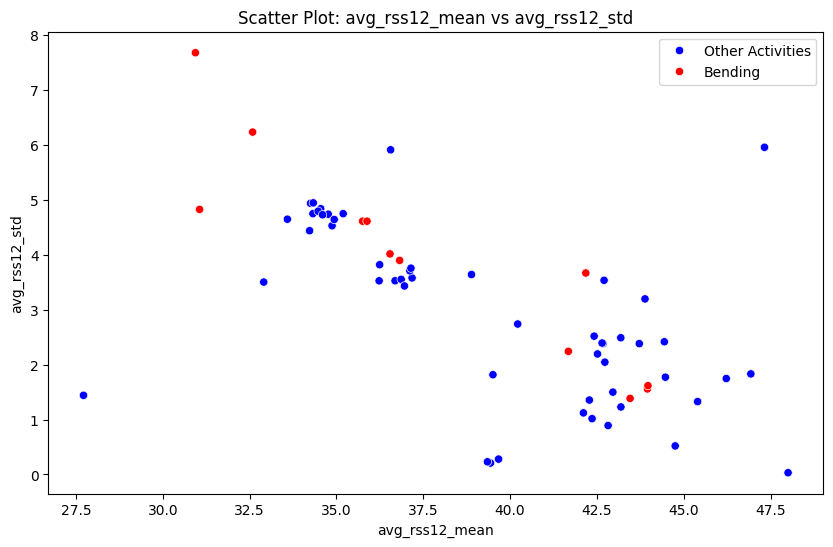

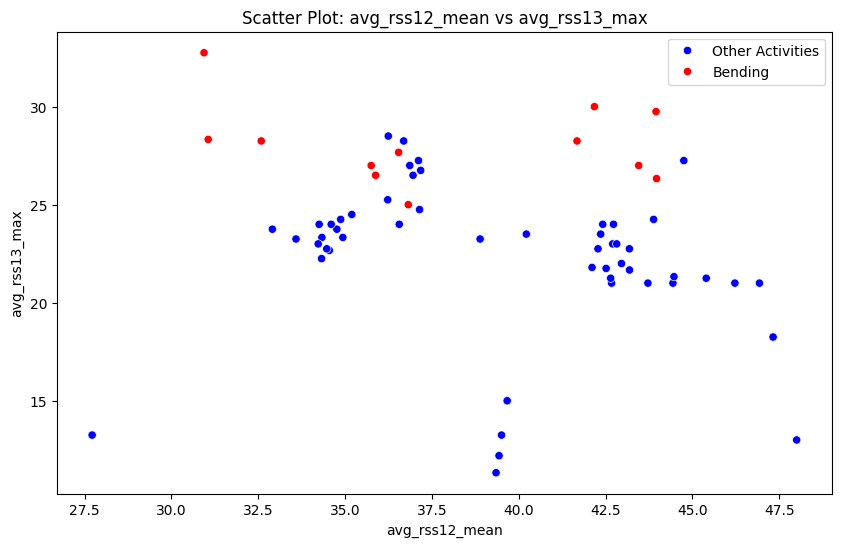

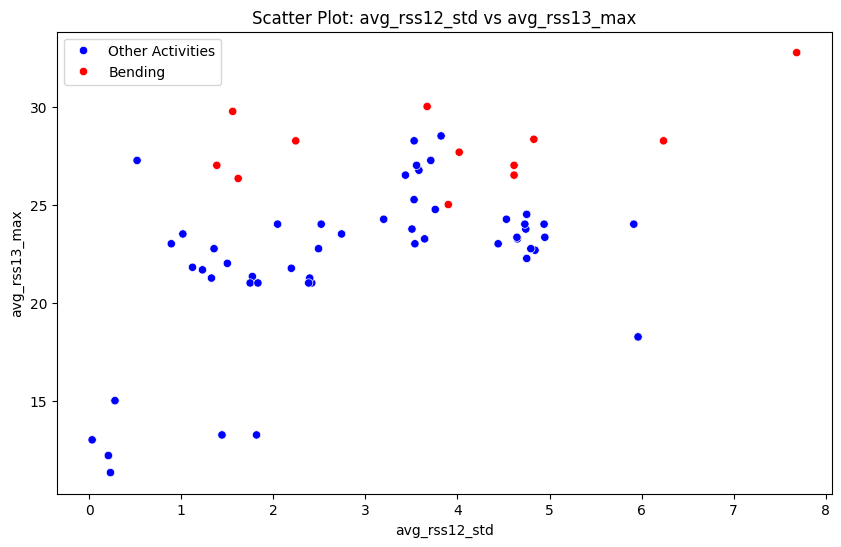

In [32]:
train_labels_binary = train_labels.apply(lambda x: 1 if 'bending' in x else 0)

# Define the color palette and label mapping
palette = ['blue', 'red']
label_mapping = {0: 'Other Activities', 1: 'Bending'}

# Scatter plot for avg_rss12_mean vs avg_rss12_std
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['avg_rss12_mean'], y=final_df['avg_rss12_std'], hue=train_labels_binary, palette=palette)
plt.title("Scatter Plot: avg_rss12_mean vs avg_rss12_std")
plt.xlabel("avg_rss12_mean")
plt.ylabel("avg_rss12_std")

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[label_mapping[int(label)] for label in labels])
plt.show()

# Scatter plot for avg_rss12_mean vs avg_rss13_max
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['avg_rss12_mean'], y=final_df['avg_rss13_max'], hue=train_labels_binary, palette=palette)
plt.title("Scatter Plot: avg_rss12_mean vs avg_rss13_max")
plt.xlabel("avg_rss12_mean")
plt.ylabel("avg_rss13_max")

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[label_mapping[int(label)] for label in labels])
plt.show()

# Scatter plot for avg_rss12_std vs avg_rss13_max
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_df['avg_rss12_std'], y=final_df['avg_rss13_max'], hue=train_labels_binary, palette=palette)
plt.title("Scatter Plot: avg_rss12_std vs avg_rss13_max")
plt.xlabel("avg_rss12_std")
plt.ylabel("avg_rss13_max")

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[label_mapping[int(label)] for label in labels])
plt.show()


#### ii. Splitted Plots

Unique values in train_labels_binary:  [1 0]
Data distribution in split_df_1:
       avg_rss12_mean_1  avg_rss12_std_1  avg_rss13_max_1
count         33.000000        33.000000        33.000000
mean          38.402978         3.013455        22.804848
std            5.017999         1.973235         6.631822
min           27.716375         0.032038        11.330000
25%           36.244083         1.442253        15.000000
50%           37.177042         3.529404        26.330000
75%           41.678063         3.900459        27.670000
max           48.004167         7.684146        32.750000
Data distribution in split_df_2:
       avg_rss12_mean_2  avg_rss12_std_2  avg_rss13_max_2
count         35.000000        35.000000        35.000000
mean          39.834068         3.034157        22.846571
std            4.600159         1.555421         1.381342
min           32.905979         0.520309        21.000000
25%           34.681604         1.760434        21.710000
50%           42.36

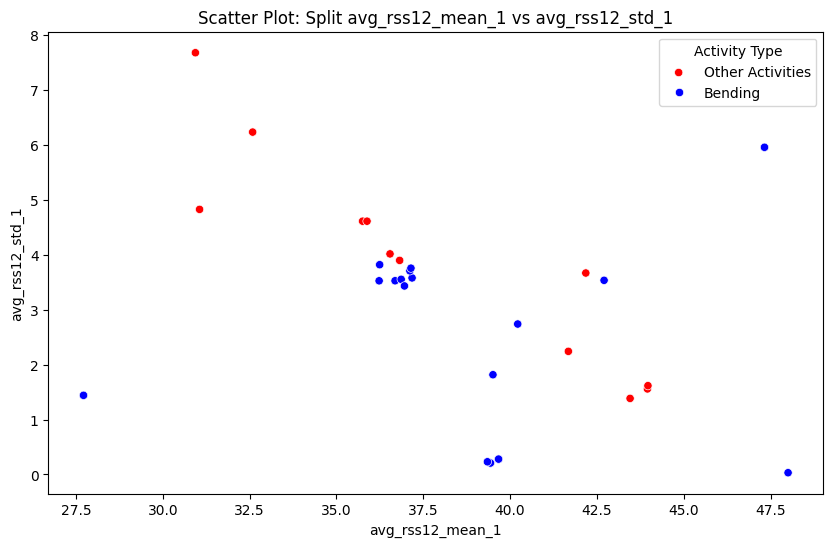

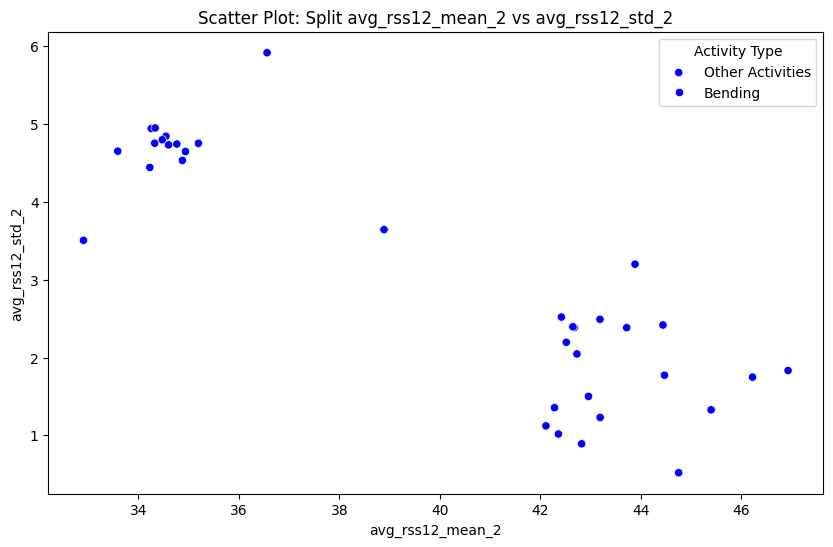

In [40]:
def split_time_series_column(df, col_name):
    mid_point = len(df) // 2
    return df[col_name][:mid_point], df[col_name][mid_point:]

train_labels_binary = train_labels.apply(lambda x: 1 if 'bending' in x else 0)

# Split the time series into two parts for each column
split_avg_rss12_mean_1, split_avg_rss12_mean_2 = split_time_series_column(final_df, 'avg_rss12_mean')
split_avg_rss12_std_1, split_avg_rss12_std_2 = split_time_series_column(final_df, 'avg_rss12_std')
split_avg_rss13_max_1, split_avg_rss13_max_2 = split_time_series_column(final_df, 'avg_rss13_max')

split_df_1 = pd.DataFrame({
    'avg_rss12_mean_1': split_avg_rss12_mean_1,
    'avg_rss12_std_1': split_avg_rss12_std_1,
    'avg_rss13_max_1': split_avg_rss13_max_1
})

split_df_2 = pd.DataFrame({
    'avg_rss12_mean_2': split_avg_rss12_mean_2,
    'avg_rss12_std_2': split_avg_rss12_std_2,
    'avg_rss13_max_2': split_avg_rss13_max_2
})

# Updated hue and palette for binary classification (bending vs. other)
hue = train_labels_binary  # Use binary labels for classification
palette = ['blue', 'red']  # Palette updated for binary classification
legend_labels = {0: 'Other Activities', 1: 'Bending'}

# Check distribution of train_labels_binary
print("Unique values in train_labels_binary: ", train_labels_binary.unique())

# Check data distribution in split_df_1 and split_df_2
print("Data distribution in split_df_1:")
print(split_df_1.describe())
print("Data distribution in split_df_2:")
print(split_df_2.describe())

# Check binary labels
print("train_labels_binary (first 10):")
print(train_labels_binary.head(10))

# Check split data frames for alignment
print("First few rows of split_df_1:")
print(split_df_1.head())
print("First few rows of split_df_2:")
print(split_df_2.head())

# Updated hue and palette for binary classification (bending vs. other)
hue = train_labels_binary  # Use binary Labels for classification
palette = ['blue', 'red']  # Palette updated for binary classification
legend_labels = {0: 'Other Activities', 1: 'Bending'}

# First part of the split time series
plt.figure(figsize=(10, 6))
sns.scatterplot(x=split_df_1['avg_rss12_mean_1'], y=split_df_1['avg_rss12_std_1'], hue=train_labels_binary, 
                palette=palette, hue_order=[0, 1])
plt.title("Scatter Plot: Split avg_rss12_mean_1 vs avg_rss12_std_1")
plt.xlabel("avg_rss12_mean_1")
plt.ylabel("avg_rss12_std_1")
plt.legend(title="Activity Type", labels=["Other Activities", "Bending"])
plt.show()

# Second part of the split time series
plt.figure(figsize=(10, 6))
sns.scatterplot(x=split_df_2['avg_rss12_mean_2'], y=split_df_2['avg_rss12_std_2'], hue=train_labels_binary, 
                palette=palette, hue_order=[0, 1])
plt.title("Scatter Plot: Split avg_rss12_mean_2 vs avg_rss12_std_2")
plt.xlabel("avg_rss12_mean_2")
plt.ylabel("avg_rss12_std_2")
plt.legend(title="Activity Type", labels=["Other Activities", "Bending"])
plt.show()




#### iii. Time Series Segments

In [27]:
# Function to split each time series into equal segments
def split_time_series(data, n_splits):
    split_data = []
    for df in data:
        split_length = len(df) // n_splits
        for i in range(n_splits):
            start = i * split_length
            end = start + split_length
            split_df = df.iloc[start:end].reset_index(drop=True)
            split_data.append(split_df)
    return split_data

# Load the test_labels and model initialization
test_labels = pd.Series(test_data)
model = LogisticRegression()

# Fit the model on the original features
model.fit(train_features_split_df, train_labels_split)

# Predict and calculate accuracy
y_pred = model.predict(test_features_split_df)
accuracy = model.score(test_features_split_df, test_labels_split)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

# Number of splits to perform
n_splits = 2

# Splitting time series for training and testing data
train_data_split = split_time_series(train_data, n_splits)
test_data_split = split_time_series(test_data, n_splits)

print(f"Total training instances after splitting: {len(train_data_split)}")
print(f"Total testing instances after splitting: {len(test_data_split)}")

# Extracting features from the split data
train_features_split = []
for df in train_data_split:
    train_features_split.append(extract_time_domain_features(df))

train_features_split_df = pd.DataFrame(train_features_split)

test_features_split = []
for df in test_data_split:
    test_features_split.append(extract_time_domain_features(df))

test_features_split_df = pd.DataFrame(test_features_split)

print("Extracted Train Features from Split Data:")
print(train_features_split_df.head())

# Prepare labels for the split data (duplicating labels for each split part)
train_labels_split = [label for label in train_labels for _ in range(n_splits)]
test_labels_split = [label for label in test_labels for _ in range(n_splits)]

# Train a logistic regression model on the split data
model_split = LogisticRegression()
model_split.fit(train_features_split_df, train_labels_split)

# Evaluate on the split test set
y_pred_split = model_split.predict(test_features_split_df)
accuracy_split = model_split.score(test_features_split_df, test_labels_split)
print(f"Model Accuracy on Split Test Data: {accuracy_split * 100:.2f}%")

# Optional cross-validation to assess performance
cv_scores = cross_val_score(model_split, train_features_split_df, train_labels_split, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")

# Check the number of rows in features and labels after splitting
print(f"Number of rows in train features: {train_features_split_df.shape[0]}")
print(f"Number of rows in train labels: {len(train_labels_split)}")

# If they don't match, check the contents of train_labels_split
print(f"First 10 elements of train_labels_split: {train_labels_split[:10]}")



NameError: name 'train_features_split_df' is not defined

#### iv. Confusion Matrix

#### v. Test Classifier

#### vi. Separation

#### vii. Imbalance

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

#### ii. Comparison

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

#### ii. Naive Bayes

#### ii. Comparison

## 3. ISLR 4.8.3

## 4. ISLR 4.8.7

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9